# <center>Wpływ danych raportów kwartalnych na przyszłe stopy zwrotu z rynku akcji</center>

### <center><i>Michał Murawski</i></center>

## 1. Sformułowanie celu

### Sformułowanie badanej hipotezy
Celem badania będzie zweryfikowanie następującej hipotezy...

**Dane publikowane kwartalnie przez firmę, są w stanie przewidzieć czy firma następnych kwartałach:**

 - **zanotuje wzrost**
 - **zanotuje wzrost większy niż indeks główny S&P500**


Niech ...
* $f$ - będzie klasyfikatorem

* $x_{1,i},..., x_{k,i}$ - to parametry publikowane kwartalnie przez firmę w dokumentach takich jak `balance sheet`, `income statement`, `cash flow statement`, `financial ratios` w kwartale $i$

* $R_{i + h}$ - to stopa zwrotu w horyzoncie inewstycyjnym $h$ licząc od kwartału $i$

    $f(x_{1,i},..., x_{k,i}) = 
\begin{cases} 
1 & \text{jeśli } log(R_{i + h}) > 0 \\
0 & \text{jeśli } log(R_{i + h}) \leq 0 
\end{cases}
$

## 2. Dane


* dane z raportów kwartalnych pobrane przy użyciu biblioteki `scrapy` ze strony [macrotredns.com](https://macrotredns.com) dla indeksu [S&P500](https://github.com/datasets/s-and-p-500-companies/blob/main/data/constituents.csv)
* dane dotyczące cen akcji zostały pobrane z [yahoo finance](http://finance.yahoo.com) przy wykorzystaniue biblioteki [yfinance](https://pypi.org/project/yfinance/)
* dane dot. inflacji z [bls.gov](https://www.bls.gov/charts/consumer-price-index/consumer-price-index-by-category-line-chart.htm) - celu korekty inflacji

<center><i><b>Scraper z powodzeniem pobrał dane 501 spółek na 504 obecnie notowanych</b></i></center>

In [29]:
!ls -1 sp500/balance-sheet/ | wc -l
!tree sp500 | head -n10

     501
sp500
├── balance-sheet
│   ├── A.csv
│   ├── AAPL.csv
│   ├── ABBV.csv
│   ├── ABNB.csv
│   ├── ABT.csv
│   ├── ACGL.csv
│   ├── ACN.csv
│   ├── ADBE.csv


In [4]:
import pandas as pd

data = pd.read_csv("sp500/data.csv")
data['date'] = pd.to_datetime(data['date'])
min_date = data['date'].min()
max_date = data['date'].max()
num_of_nans = (data.isna().sum()/len(data) * 100).sort_values(ascending=False)
print(len(num_of_nans[num_of_nans>0])/len(num_of_nans))
print(min_date, max_date)
data = data.set_index(keys=['date', 'ticker'])

0.5463917525773195
2009-01-31 00:00:00 2024-11-30 00:00:00


## 3. Wstępna ocena danych
* Dane udało się pobrać z powodzeniem od dla 501 firm
* W sumie ok. 24 tys. wierszy po 93 kolumny
* Przedziale czasowym 2009-01-31 do 2024-11-30

* Braki w danych występują w ok. 55% rekordów. Główne czynniki braków: 
    - Zmieniające się regulacje SEC dot wymagań w raportach kwartalnych
    - Preferencje firmy
    - Typ firmy (np. banki często nie notują marży brutto)

* Po integracji danych z Yahoo Finance udało się zdobyć dane 494 firm
* Wstępnie sprawdzono korelacje przyszłych zwrotów z parametrami w danych

In [5]:
data.describe()

,current_ratio,long_term_debt_capital,debt_equity_ratio,gross_margin,operating_margin,ebit_margin,pre_tax_profit_margin,net_profit_margin,asset_turnover,inventory_turnover,...,financial_activities_other,cash_flow_from_financial_activities,net_cash_flow,stock_based_compensation,common_stock_dividends_paid,long_term_investments,net_change_in_long_term_investments,research_development_expenses,net_change_in_intangible_assets,other_income
count,25820.000000,29378.000000,29631.000000,25820.000000,28846.000000,28846.000000,30018.000000,30018.000000,30018.000000,20838.000000,...,29829.000000,30018.000000,30018.000000,25648.000000,25732.000000,18681.000000,25206.000000,10372.000000,6624.000000,880.000000
mean,1.855805,0.522186,1.124538,47.277555,12.423314,12.403643,10.608941,5.756669,0.184429,3.149659,...,181.718713,-185.507501,58.626883,59.274381,-255.334314,21809.293898,-147.746442,434.604396,-29.582525,7.837288
std,1.442581,9.461567,37.766890,125.345803,214.574107,214.369061,336.251807,334.563889,0.172041,14.603845,...,4367.480453,5518.556001,3858.045485,251.394768,493.365954,81040.346682,3481.766031,1194.441779,598.345809,128.003467
min,0.000000,-71.366600,-1294.600000,-6379.194000,-18427.940000,-18427.940000,-44144.000000,-44199.740000,-0.789100,-6.045700,...,-113848.000000,-142344.000000,-140304.000000,-1885.000000,-7304.000000,0.000000,-179706.000000,-1429.000000,-44783.000000,-71.693000
25%,1.033450,0.248125,0.315750,29.228150,8.548025,8.549425,6.855600,5.008925,0.075800,0.797475,...,-15.000000,-461.000000,-129.000000,5.924250,-238.000000,1.325000,-17.000000,30.624000,-0.800000,0.000000
50%,1.460350,0.397100,0.676500,44.732550,15.432000,15.455200,13.627100,10.422650,0.142050,1.305700,...,-0.704000,-111.105000,5.969000,15.200000,-96.000000,424.000000,0.000000,116.000000,0.000000,0.000000
75%,2.219500,0.550600,1.225350,65.922100,23.741825,23.797200,22.583200,17.908475,0.233500,2.464175,...,2.640000,13.588500,170.000000,39.000000,-28.000000,3694.000000,0.000000,346.000000,0.000000,0.000000
max,21.988700,1500.000000,5579.360000,16433.330000,19700.000000,19700.000000,21966.670000,13666.670000,2.634900,1505.057000,...,301418.000000,362305.000000,183463.000000,7127.000000,3199.000000,982627.000000,99880.000000,22304.000000,2309.000000,3723.479000


In [6]:
num_of_nans[num_of_nans>0].to_frame()

,0
other_income,97.068426
other_share_holders_equity,82.503831
net_change_in_intangible_assets,77.933240
research_development_expenses,65.447398
income_from_discontinued_operations,47.914585
pre_paid_expenses,46.578719
net_change_in_short_term_investments,39.856086
long_term_investments,37.767340
change_in_accounts_payable,34.022920
other_current_assets,31.484443


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

HORIZON = 4
correlation_data = dict()
features_for_correlations = [f'log_return_q{i}' for i in range(1, HORIZON + 1)] + [f'diff_q{i}' for i in range(1, HORIZON + 1)]

#for feat in features_for_correlations:
#    correlation_data[f"{feat}"] = pd.read_csv(f'sp500/features_pearson_correlation_{feat}.csv')
correlation_data["diff_q1"] = pd.read_csv(f'sp500/features_pearson_correlation_diff_q1.csv')
correlation_data["diff_q2"] = pd.read_csv(f'sp500/features_pearson_correlation_diff_q2.csv')
correlation_data["diff_q3"] = pd.read_csv(f'sp500/features_pearson_correlation_diff_q3.csv')
correlation_data["diff_q4"] = pd.read_csv(f'sp500/features_pearson_correlation_diff_q4.csv')

correlation_data["log_return_q1"] = pd.read_csv(f'sp500/features_pearson_correlation_log_return_q1.csv')
correlation_data["log_return_q2"] = pd.read_csv(f'sp500/features_pearson_correlation_log_return_q2.csv')
correlation_data["log_return_q3"] = pd.read_csv(f'sp500/features_pearson_correlation_log_return_q3.csv')
correlation_data["log_return_q4"] = pd.read_csv(f'sp500/features_pearson_correlation_log_return_q4.csv')

def plot_correlation(data, title='Feature correlations with targets'):
    num_of_columns = 4
    rest =  len(data) % num_of_columns
    rows = len(data) // num_of_columns
    if rest:
        rows += 1
    fig, axs = plt.subplots(rows, num_of_columns)

    for i, feat in enumerate(data.keys()):
        row = i % num_of_columns
        col = (i // num_of_columns)
        x = data[feat].dropna()
        x = x.loc[x['p-value'] < 0.05]
        positive_df = x.loc[x['correlation'] > 0]
        negative_df = x.loc[x['correlation'] <= 0]
        axs[col][row].scatter(positive_df['correlation'], positive_df['p-value'], c='blue', label=f'Positive Correlation with {feat}', alpha=0.007)
        axs[col][row].scatter(negative_df['correlation'], negative_df['p-value'], c='red', label=f'Negative Correlation with {feat}', alpha=0.007)
        axs[col][row].set_xlabel('correlation')
        axs[col][row].set_ylabel('p-value')
        axs[col][row].set_title(f"{feat}")
        axs[col][row].grid(linestyle='--')
        axs[col][row].set_xlim(-1.0, 1.0)

    fig.set_figheight(10)
    fig.set_figwidth(15)
    fig.tight_layout(h_pad=0.01)
    #fig.suptitle('Feature correlations with targets')

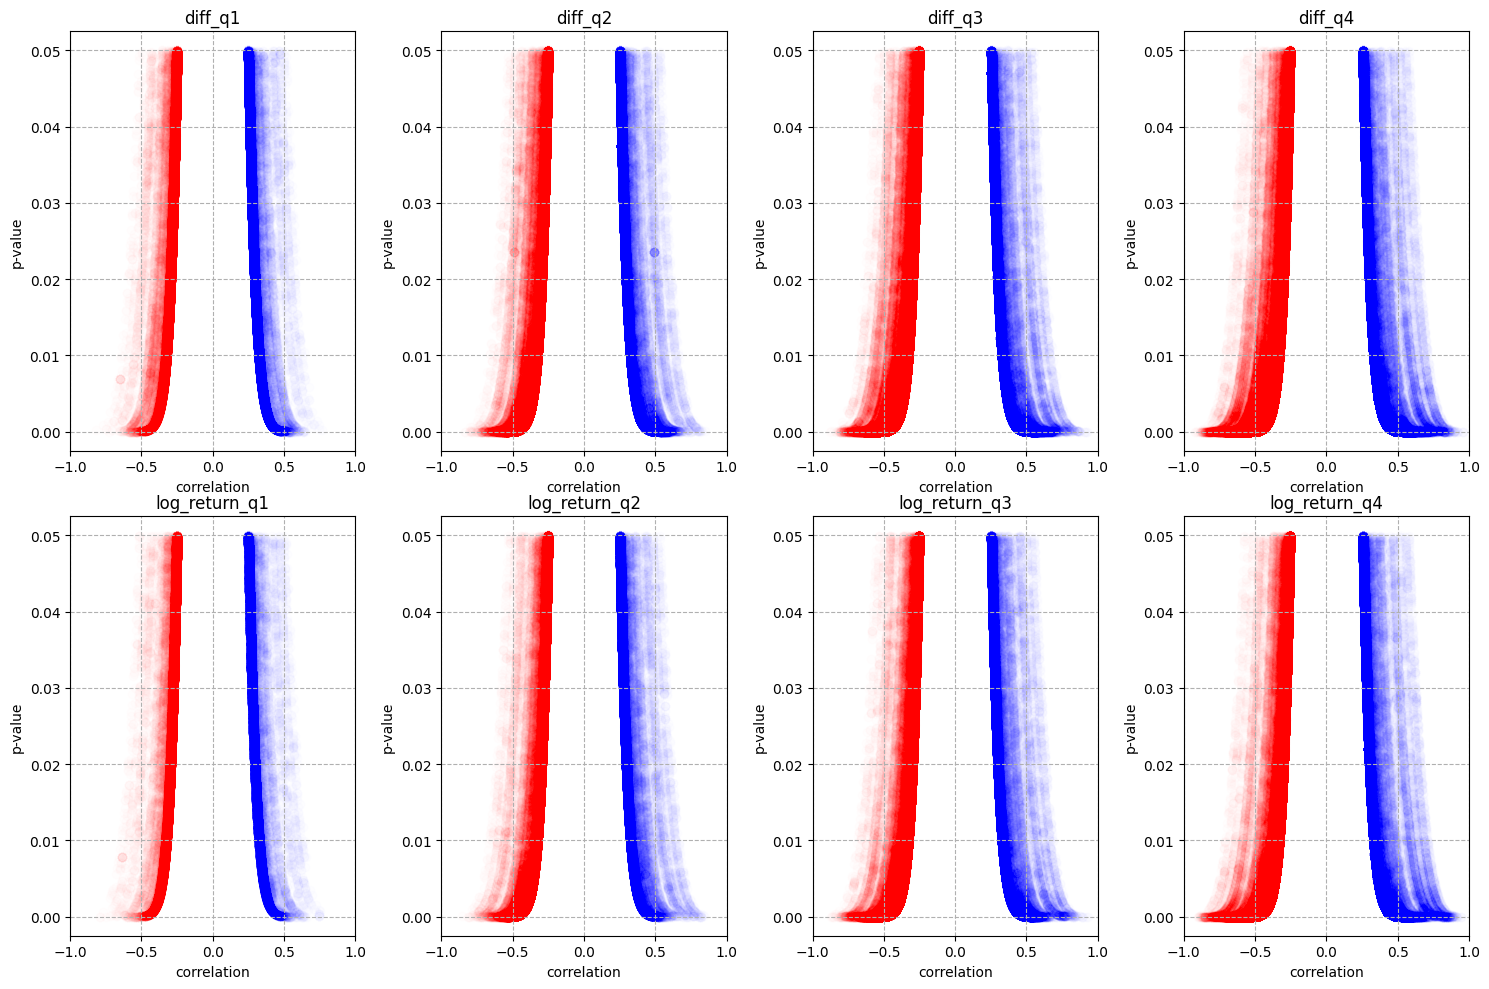

In [2]:
plot_correlation(correlation_data)

## 4. Przygotowanie danych

### Brakujące dane
* dane uzupełniono w polach `market_cap`, `gross_margin`, `operating_margin`, `free_cash_flow_per_share`, `current_ratio`, `ebit`, `ebitda`
* odrzucono wszystkie firmy które nie zanotowały `gross_margin`
* następnie odrzucono kolumny w których występowały brakujące dane

### Integracja danych
* dane z yahoo finance, kredytowe zintegrowano do wspólnej tabeli

### Wzbogacanie
* parametry które opisują dynamikę zmian wcześniej istniejących parametrów w różnych przedziałach. 

    Na przykład: `asset_turnover_change_XY`
* percentyle dot. poszczególnych parametrów - w celu określenia jak binzes odstane na tle innych 

    Na przykład: `asset_turnover_change_XY_percentile`
* dane zostały wzbogacone o takie parametry jak cena, logarytm z przyszłych stóp zwrotu dla następnych 4 kwartałów

    `price`, `log_return_q1`, `log_return_q2`, `log_return_q3`, `log_return_q4` 
* binarne klasy do klasyfikacji
    - `class_1` - 1 kiedy notowane są wzrosty (`class_1_q1`, `class_1_q2`, ...)
    - `class_2` - 1 kiedy notowane są wzroty powyżej głównego indeksu S&P500
* różnice pomiędzy zwrotami, a zwrotami z S&P500 do badania korelacji

### Selekcja atrybutów
* dla każdej firmy została obliczona macierz korelacji
* następnie macierze zostały uśrednione wykorzystując tzw. tranformację fishera
* wybrano następnie atrybuty, które miały korelację powyżej 3%, odrzucono parametry, które silnie korelowały między sobą powyżej 50%

* **finalnie jednak ustalono pewne parametry bazowe i następnie wzbogacano je o dodatkowo wyselekcjonowame z macierzy korelacji**
```python
attributes = base_attributes + selected_attributes
```

Źródła:
* [Averaging Correlations](https://medium.com/@jan.seifert/averaging-correlations-part-i-3adab6995042)

<p align="center">
  <img src="correlation_matrix.png" width="1200" height="500"/>
</p>

# 5. Modelowanie
* `XGBoostClassifier`, `RandomForestClassifier` + `StandardScaler`
* `RandomizedSearchCV` - fold: 4, 3 rożne kombinacje hipper-parametrów
* zaimplementowano cv splitter `BalancedQuarterTimeSeriesSplit` w celu zbalansowania klas i zastosowania odpowiedniego podziału danych podczas walidacji krzyżowej
* w zależności od modelu p ~ 70, n ~ 28675
<p align="center">
  <img src="cv.png"/>
</p>

# 6. Ewaluacja ocena i selekcja najlepszych modeli

<!DOCTYPE html>
<html>
<head>
    <style>
        .grid-container {
            display: grid;
            grid-template-columns: repeat(2, 1fr);
            gap: 10px;
            width: 100%;
            aspect-ratio: 2;
        }
        .grid-item img {
            width: 100%;
            height: 100%;
            object-fit: contain;
            display: block;
        }
    </style>
</head>
<body>
    <div class="grid-container">
        <div class="grid-item">
            <img src="confustion_matrix_class_1_q1.png" alt="Image 1">
        </div>
        <div class="grid-item">
            <img src="confustion_matrix_class_1_q2.png" alt="Image 2">
        </div>
        <div class="grid-item">
            <img src="confustion_matrix_class_1_q3.png" alt="Image 3">
        </div>
        <div class="grid-item">
           <img src="confustion_matrix_class_1_q4.png" alt="Image 3">
        </div>
    </div>
</body>
</html>

In [31]:
def make_plot_1():
    import matplotlib.pyplot as plt
    import numpy as np

    def calculate_metrics(tn, fp, fn, tp):
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        return accuracy, precision, recall, f1
    matrices_data = {
        'XGBC Q1': [1549, 1211, 1099, 1661],
        'RFC Q1': [1200, 1560, 631, 2129],
        'XGBC Q2': [1590, 1235, 1037, 1788],
        'RFC Q2': [1482, 1343, 784, 2041],
        'XGBC Q3': [1488, 1625, 987, 2126],
        'RFC Q3': [1584, 1529, 920, 2193],
        'XGBC Q4': [952, 1841, 622, 2171],
        'RFC Q4': [862, 1931, 689, 2104]
    }

    # Calculate metrics
    metrics = {name: calculate_metrics(*values) for name, values in matrices_data.items()}

    # Prepare data for plotting
    quarters = ['Q1', 'Q2', 'Q3', 'Q4']
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

    # Create figure with subplots for each metric
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()

    for idx, metric_name in enumerate(metrics_names):
        xgbc_values = [metrics[f'XGBC {q}'][idx] for q in quarters]
        rfc_values = [metrics[f'RFC {q}'][idx] for q in quarters]

        axes[idx].plot(quarters, xgbc_values, 'o-', label='XGBC')
        axes[idx].plot(quarters, rfc_values, 's-', label='RFC')
        axes[idx].set_title(metric_name)
        axes[idx].set_ylim(0.5, 0.8)
        axes[idx].grid(True, alpha=0.3)
        axes[idx].legend()

    plt.tight_layout()
    plt.show()

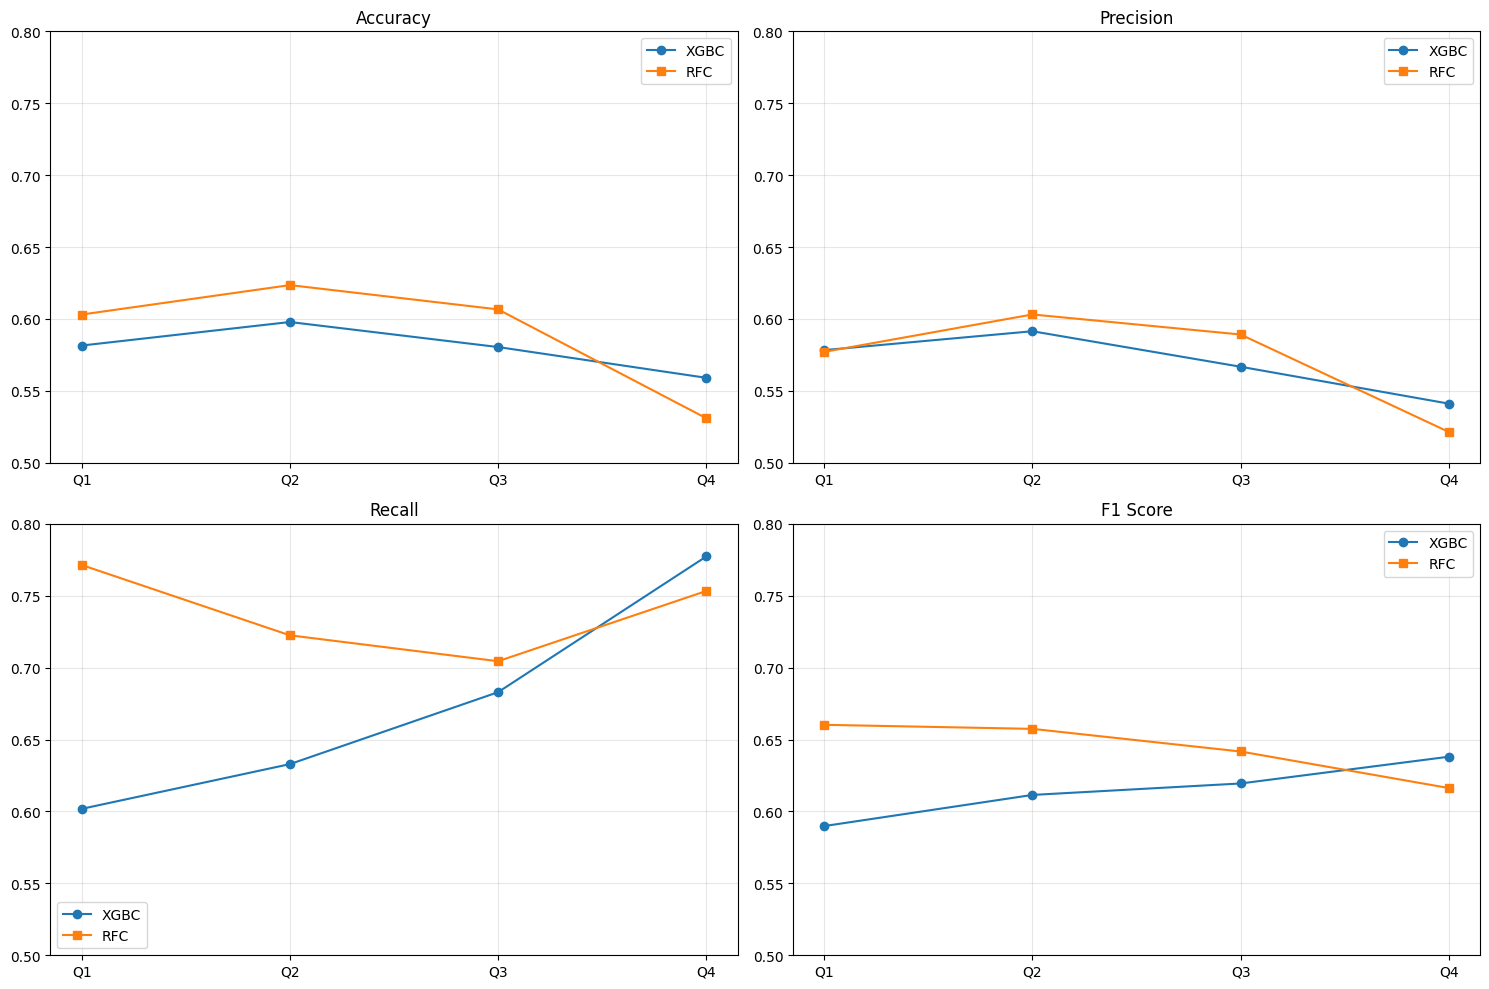

In [32]:
make_plot_1()

## Parametry

In [28]:
rfc_parameters_importance_q1 = {
    "DRSDCILM": 0.17494564043144473,
    "DRTSCILM": 0.16961008898797086,
    "DRISCFLM": 0.12499793873574225,
    "market_cap": 0.010595851265864063,
    "net_change_in_property_plant_equipment": 0.009929252782444276,
    "current_ratio": 0.009823644444351026,
    "gross_margin": 0.009163099101814906,
    "net_cash_flow": 0.009091049468869968,
    "fcf_growth_QoQ": 0.008407077909051899,
    "free_cash_flow_per_share_zscore_1Y": 0.008384811512931186,
    "cash_on_hand": 0.008153444239149505,
    "asset_turnover_change_3Y": 0.007925038423497687,
    "free_cash_flow_per_share": 0.007882897376628444,
    "book_value_per_share": 0.007857281509156273,
    "asset_turnover_change_2Y": 0.007741349082612421,
    "cash_flow_from_investing_activities": 0.0077337995693194305,
    "total_change_in_assets_liabilities": 0.007604470424772811,
    "cash_flow_from_financial_activities": 0.007420233918185564,
    "asset_turnover_change_4Y": 0.007301479252547626,
    "free_cash_flow_per_share_zscore_5Y": 0.007277634705002653,
    "other_non_cash_items": 0.007273523582666127,
    "retained_earnings_accumulated_deficit": 0.006916421389578255,
    "net_profit_margin": 0.006794338599732833,
    "asset_turnover": 0.006636254809675321,
    "asset_turnover_change_QoQ": 0.006599653547325269,
    "roe_change_4Y": 0.00642887460646067,
    "return_on_tangible_equity": 0.0064178660115060395,
    "roa_zscore_1Y": 0.006316043320795016,
    "net_common_equity_issued_repurchased": 0.0062714625621387386,
    "revenue_growth_YoY": 0.00626935909481029,
    "debt_equity_ratio_zscore_1Y": 0.006255557435404743,
    "free_cash_flow_per_share_zscore_3Y": 0.006248809753865736,
    "total_non_cash_items": 0.006222503269230452,
    "total_share_holder_equity": 0.006207593431966817,
    "roe_change_YoY": 0.0060407141743779634,
    "sector_Utilities": 0.006010060470710144,
    "roe_change_2Y": 0.005977405652922279,
    "debt_equity_ratio_zscore_3Y": 0.0059563584381065,
    "net_total_equity_issued_repurchased": 0.0059160023145919,
    "revenue_zscore_1Y": 0.0057065386505517485,
    "roa_zscore_3Y": 0.005703487993032924,
    "operating_cash_flow_per_share": 0.005673034223266009,
    "debt_equity_ratio_zscore_5Y": 0.005660141220987228,
    "roe_change_QoQ": 0.005584411644413508,
    "roa_zscore_5Y": 0.00549034470488174,
    "revenue_growth_QoQ": 0.005459630629026423,
    "total_current_assets": 0.005413808833658397,
    "asset_turnover_zscore_1Y": 0.005323029373666836,
    "total_long_term_liabilities": 0.0053206667502771875,
    "roe_zscore_3Y": 0.005285099481340902,
    "roe_zscore_5Y": 0.005281307208760449,
    "fcf_growth_YoY": 0.0052733987580446595,
    "roi": 0.005243579490755787,
    "fcf_cagr_1Y": 0.005239730130996433,
    "total_long_term_assets": 0.0052358429660432915,
    "asset_turnover_zscore_3Y": 0.005227992934440162,
    "total_depreciation_amortization_cash_flow": 0.005146809464983649,
    "asset_turnover_zscore_5Y": 0.005069159053161227,
    "debt_equity_ratio": 0.00498261087529518,
    "pre_tax_profit_margin": 0.004966352070118315,
    "roe_zscore_1Y": 0.004950918240759185,
    "revenue_zscore_3Y": 0.0047918973191641906,
    "shares_outstanding": 0.004786381028907774,
    "basic_shares_outstanding": 0.004782757367779002,
    "roa": 0.004776853749055587,
    "operating_margin": 0.004708843204285551,
    "asset_turnover_change_YoY": 0.004499863482461549,
    "ebit_margin": 0.004486789711311944,
    "revenue_zscore_5Y": 0.004470997108456483,
    "asset_turnover_change_1Y": 0.004466675359749946,
    "cash_flow_from_operating_activities": 0.004360031015251785,
    "roe": 0.004331401372236395,
    "eps_earnings_per_share_diluted": 0.0042082561044636145,
    "total_current_liabilities": 0.004180877904413974,
    "eps_basic_net_earnings_per_share": 0.004164604349596726,
    "revenue": 0.004058244533265882,
    "gross_profit": 0.003899157247533941,
    "total_liabilities": 0.0036907934686543965,
    "total_liabilities_share_holders_equity": 0.0031595265535179526,
    "ebitda": 0.0030259860843327912,
    "total_assets": 0.0029226963935458914,
    "pre_tax_income": 0.0028176252255773175,
    "free_cash_flow_per_share_percentile_5Y": 0.0026686623368841565,
    "net_income_loss": 0.0026215862276238737,
    "net_income": 0.0024160213874714204,
    "operating_income": 0.0023998096288429097,
    "ebit": 0.0022295675421437774,
    "income_from_continuous_operations": 0.002100160379972185,
    "income_after_taxes": 0.0020771992796471254,
    "debt_equity_ratio_percentile_5Y": 0.0017802322664813605,
    "gross_margin_change_YoY_signal": 0.001674795852950699,
    "asset_turnover_percentile_5Y": 0.0015900817986376412,
    "roe_percentile_5Y": 0.0015853244607710554,
    "operating_margin_percentile_1Y_signal": 0.0015251139806234603,
    "inventory_turnover_percentile_1Y_signal": 0.0014470645393459259,
    "free_cash_flow_per_share_percentile_3Y": 0.0014444410616572905,
    "sector_Health Care": 0.0013956363254774677,
    "revenue_percentile_5Y": 0.0013404167383487674,
    "debt_equity_ratio_percentile_3Y": 0.001330953876348445,
    "current_ratio_percentile_1Y_signal": 0.0013293603790892783,
    "roa_percentile_5Y": 0.0012914420577704129,
    "operating_margin_percentile_3Y_signal": 0.0012881171543579048,
    "sector_Consumer Staples": 0.0011855241126974858,
    "revenue_percentile_3Y": 0.0011479292459704658,
    "roe_percentile_3Y": 0.0011213856629363962,
    "asset_turnover_percentile_3Y": 0.001089953291572207,
    "revenue_cagr_5Y": 0.0010694534157205224,
    "gross_margin_percentile_1Y_signal": 0.0010059795479151568,
    "roa_percentile_3Y": 0.0009360127388217988,
    "sector_Industrials": 0.0008652912978439756,
    "sector_Energy": 0.000862062128846676,
    "operating_margin_percentile_5Y_signal": 0.0008597706013611197,
    "revenue_cagr_3Y": 0.0008199501919163311,
    "roe_change_5Y": 0.0007475150448105305,
    "operating_margin_change_3Y": 0.000633154718366261,
    "sector_Information Technology": 0.0005940351869140418,
    "free_cash_flow_per_share_percentile_1Y_signal": 0.0005705448543188121,
    "free_cash_flow_per_share_percentile_1Y": 0.0005632448374557122,
    "debt_equity_change_YoY_signal": 0.0005613534042038714,
    "free_cash_flow_per_share_percentile_5Y_signal": 0.000546308741619396,
    "free_cash_flow_per_share_percentile_3Y_signal": 0.0005330092074336623,
    "operating_margin_change_5Y": 0.0004805462772938775,
    "gross_margin_percentile_3Y_signal": 0.0004750854725548987,
    "debt_equity_ratio_percentile_1Y": 0.00045253737915452443,
    "sector_Consumer Discretionary": 0.0004512796364404382,
    "current_ratio_percentile_3Y_signal": 0.0004244899375578342,
    "sector_Financials": 0.0004220270767186168,
    "roe_percentile_1Y_signal": 0.0004081473219555082,
    "roa_percentile_1Y_signal": 0.0004035404997983291,
    "debt_equity_ratio_percentile_3Y_signal": 0.00040161779554449416,
    "roa_percentile_1Y": 0.00039524302949525746,
    "asset_turnover_percentile_1Y_signal": 0.00039294592704471385,
    "revenue_percentile_1Y": 0.0003916239800846289,
    "roa_percentile_3Y_signal": 0.0003774520853687022,
    "revenue_percentile_1Y_signal": 0.00036776779864081756,
    "asset_turnover_percentile_1Y": 0.00036575480490265287,
    "debt_equity_ratio_percentile_5Y_signal": 0.0003638945679962114,
    "roe_percentile_1Y": 0.0003612555681689971,
    "debt_equity_ratio_percentile_1Y_signal": 0.000353218141669515,
    "revenue_cagr_1Y": 0.00035061997536206643,
    "operating_margin_change_YoY_signal": 0.0003346601660771407,
    "asset_turnover_percentile_5Y_signal": 0.0003329997226201326,
    "roe_change_3Y": 0.00033044610859425536,
    "roe_percentile_3Y_signal": 0.0003303585075477907,
    "asset_turnover_percentile_3Y_signal": 0.000323747911679022,
    "operating_margin_change_1Y": 0.0003001668134756177,
    "revenue_percentile_3Y_signal": 0.0002972454604086026,
    "sector_Communication Services": 0.00028656171190889296,
    "roe_percentile_5Y_signal": 0.0002783396566693044,
    "revenue_percentile_5Y_signal": 0.0002650671469512949,
    "sector_Materials": 0.00026444917781765864,
    "fcf_growth_YoY_signal": 0.0002458066845470375,
    "roa_percentile_5Y_signal": 0.00023096235043864235,
    "revenue_growth_YoY_signal": 0.0002038952079402273,
    "roe_change_1Y": 0.00019279697369668585,
    "asset_turnover_change_YoY_signal": 0.00015678307044064002,
    "roe_change_YoY_signal": 0.0001423330317957997,
    "sector_Real Estate": 9.021181777928303e-05,
    "inventory_turnover_percentile_3Y_signal": 5.1729664551560766e-05,
    "gross_margin_percentile_5Y_signal": 2.0743775936249983e-05,
    "current_ratio_percentile_5Y_signal": 1.4336895590995703e-07,
    "inventory_turnover_percentile_5Y_signal": 0.0
}

In [33]:
xgb_parameter_importance_cls_1_q2 = {
    "market_cap": 2912.0,
    "DRISCFLM": 2788.0,
    "net_cash_flow": 2742.0,
    "gross_margin": 2715.0,
    "other_non_cash_items": 2706.0,
    "DRTSCILM": 2694.0,
    "cash_flow_from_financial_activities": 2666.0,
    "DRSDCILM": 2596.0,
    "return_on_tangible_equity": 2573.0,
    "cash_on_hand": 2567.0,
    "cash_flow_from_investing_activities": 2508.0,
    "total_change_in_assets_liabilities": 2505.0,
    "book_value_per_share": 2494.0,
    "asset_turnover": 2366.0,
    "retained_earnings_accumulated_deficit": 2341.0,
    "free_cash_flow_per_share": 2301.0,
    "operating_cash_flow_per_share": 2124.0,
    "net_common_equity_issued_repurchased": 2101.0,
    "total_non_cash_items": 2031.0,
    "roe": 2006.0,
    "pre_tax_profit_margin": 1967.0,
    "total_long_term_liabilities": 1883.0,
    "net_profit_margin": 1879.0,
    "roa": 1867.0,
    "total_depreciation_amortization_cash_flow": 1859.0,
    "total_current_liabilities": 1737.0,
    "cash_flow_from_operating_activities": 1721.0,
    "total_current_assets": 1718.0,
    "roi": 1709.0,
    "net_total_equity_issued_repurchased": 1674.0,
    "total_share_holder_equity": 1502.0,
    "gross_profit": 1497.0,
    "shares_outstanding": 1435.0,
    "eps_earnings_per_share_diluted": 1425.0,
    "revenue": 1411.0,
    "total_long_term_assets": 1362.0,
    "basic_shares_outstanding": 1220.0,
    "ebitda": 1208.0,
    "total_liabilities": 1179.0,
    "eps_basic_net_earnings_per_share": 1135.0,
    "operating_income": 1078.0,
    "total_liabilities_share_holders_equity": 1033.0,
    "net_income_loss": 923.0,
    "pre_tax_income": 922.0,
    "net_income": 841.0,
    "income_from_continuous_operations": 724.0,
    "income_after_taxes": 601.0,
    "revenue_cagr_5Y_signal": 528.0,
    "revenue_cagr_3Y_signal": 469.0,
    "operating_margin_change_3Y_signal": 461.0,
    "debt_equity_change_YoY_signal": 450.0,
    "operating_margin_change_5Y_signal": 409.0,
    "ebit": 402.0,
    "roe_change_5Y_signal": 369.0,
    "operating_margin_change_1Y_signal": 362.0,
    "asset_turnover_change_YoY_signal": 336.0,
    "roe_change_3Y_signal": 315.0,
    "total_assets": 314.0,
    "fcf_growth_YoY_signal": 309.0,
    "gross_margin_change_YoY_signal": 275.0,
    "revenue_cagr_1Y_signal": 266.0,
    "sector_Consumer Staples": 258.0,
    "roe_change_YoY_signal": 250.0,
    "roe_change_1Y_signal": 168.0,
    "sector_Health Care": 139.0,
    "revenue_growth_YoY_signal": 135.0,
    "sector_Financials": 124.0,
    "operating_margin_change_YoY_signal": 117.0,
    "sector_Consumer Discretionary": 110.0,
    "sector_Utilities": 104.0,
    "sector_Energy": 97.0,
    "sector_Industrials": 84.0,
    "sector_Information Technology": 84.0,
    "sector_Materials": 38.0,
    "sector_Real Estate": 30.0,
    "sector_Communication Services": 10.0
}

# 7. Wnioski

* RFC konsekwentnie wykazuje wyższą czułość(recall) **(0,77-0,72)** w porównaniu do XGBC **(0,60-0,63)**, co oznacza lepszą zdolność do identyfikacji rzeczywistych zwycięzców.
* Precyzja jest porównywalna między modelami, przy czym XGBC ma niewielką przewagę w Q2-Q3 **(około 0,59-0,60)**.
* F1-score faworyzuje RFC **(0,66-0,65)** nad XGBC **(0,59-0,61)**, co sugeruje lepszą ogólną równowagę między precyzją a czułością.
* Oba modele wykazują stabilność w kolejnych kwartałach, ale RFC utrzymuje bardziej spójną wydajność.

**Rekomendacja: RFC jest lepszym wyborem, ponieważ**:

* Osiąga wyższe i bardziej stabilne wartości F1-score
* Posiada znacznie lepszą czułość przy porównywalnej precyzji
* Wykazuje bardziej spójną wydajność w kolejnych kwartałach, co sugeruje lepszą uogólnialność

```bash
              precision    recall  f1-score   support

         0.0       0.68      0.42      0.52      2760
         1.0       0.58      0.80      0.67      2760

    accuracy                           0.61      5520
   macro avg       0.63      0.61      0.60      5520
weighted avg       0.63      0.61      0.60      5520
```


```python
Best parameters for RandomForestClassifier:
{
    'clf__max_depth': 11,
    'clf__max_features': np.float64(0.621177788741951),
    'clf__min_samples_leaf': 2,
    'clf__min_samples_split': 9,
    'clf__n_estimators': 852
}
```

In [37]:
parameters = {'DRSDCILM': 0.19839902540098467, #p= 75
 'DRTSCILM': 0.17450358081428463,
 'DRISCFLM': 0.12551544146496738,
 'market_cap': 0.020627102058584545,
 'pre_tax_profit_margin': 0.0177151808998295,
 'gross_margin': 0.017689557207352744,
 'net_profit_margin': 0.016650607444918277,
 'asset_turnover': 0.016492245379529705,
 'free_cash_flow_per_share': 0.016198397909385074,
 'cash_on_hand': 0.014444110116870754,
 'total_change_in_assets_liabilities': 0.013421118663431385,
 'net_cash_flow': 0.01319227583198072,
 'book_value_per_share': 0.01299482569920519,
 'retained_earnings_accumulated_deficit': 0.012408797932871182,
 'return_on_tangible_equity': 0.012095898222247282,
 'cash_flow_from_financial_activities': 0.012011356836285113,
 'cash_flow_from_investing_activities': 0.011928927043516068,
 'operating_cash_flow_per_share': 0.011846230728156961,
 'total_depreciation_amortization_cash_flow': 0.011729568478120019,
 'total_non_cash_items': 0.01141401811959367,
 'roa': 0.01129745603448907,
 'net_common_equity_issued_repurchased': 0.011248961138894478,
 'roi': 0.011019440574847132,
 'roe': 0.01098018466196646,
 'other_non_cash_items': 0.010747274597981563,
 'total_current_assets': 0.010387672249788713,
 'net_total_equity_issued_repurchased': 0.01026958040197548,
 'sector_Utilities': 0.01002076694449414,
 'total_long_term_liabilities': 0.009812160718128933,
 'revenue': 0.00937238560279098,
 'total_current_liabilities': 0.008956373071886035,
 'cash_flow_from_operating_activities': 0.008809393320850675,
 'total_share_holder_equity': 0.008575058687539232,
 'total_long_term_assets': 0.008396162320060125,
 'gross_profit': 0.007551124657554429,
 'total_liabilities': 0.00708850482638671,
 'basic_shares_outstanding': 0.007075605771337767,
 'eps_earnings_per_share_diluted': 0.006955244619699013,
 'shares_outstanding': 0.006752779200232448,
 'eps_basic_net_earnings_per_share': 0.006604014529666768,
 'ebitda': 0.00608158961689697,
 'pre_tax_income': 0.004898320213899836,
 'sector_Financials': 0.004667472545308165,
 'total_liabilities_share_holders_equity': 0.004501082284352983,
 'total_assets': 0.0042302045506679925,
 'net_income_loss': 0.00419405981135939,
 'net_income': 0.0041655808131146185,
 'operating_income': 0.0040036334082004035,
 'ebit': 0.0039118368421017504,
 'income_after_taxes': 0.0034069526477013795,
 'income_from_continuous_operations': 0.003298587996288392,
 'sector_Consumer Staples': 0.002657191725132977,
 'revenue_cagr_5Y_signal': 0.0021920639598844833,
 'sector_Industrials': 0.0020963429403651848,
 'sector_Energy': 0.0018510595548078747,
 'sector_Health Care': 0.001678765239196181,
 'revenue_cagr_3Y_signal': 0.0015819309182017376,
 'operating_margin_change_3Y_signal': 0.001433669862527584,
 'sector_Real Estate': 0.001430832313339345,
 'debt_equity_change_YoY_signal': 0.001171173393132177,
 'sector_Materials': 0.0011615672344963434,
 'revenue_cagr_1Y_signal': 0.0011378817978218675,
 'sector_Information Technology': 0.0011101580784633606,
 'fcf_growth_YoY_signal': 0.0011012273848120555,
 'gross_margin_change_YoY_signal': 0.0010558224054946876,
 'roe_change_5Y_signal': 0.0009839114442678324,
 'sector_Consumer Discretionary': 0.0009213016161757181,
 'roe_change_1Y_signal': 0.0008798016036697207,
 'asset_turnover_change_YoY_signal': 0.0008563231863502996,
 'operating_margin_change_1Y_signal': 0.0007899222004520027,
 'roe_change_3Y_signal': 0.0007855155649904269,
 'operating_margin_change_YoY_signal': 0.0007694990369058684,
 'revenue_growth_YoY_signal': 0.0006965488470800041,
 'roe_change_YoY_signal': 0.0006313685246618516,
 'sector_Communication Services': 0.0004683902551936416}

**Co można było poprawić?**:
 * Selekcja cech - uważam, że proste liczenie korelacji spearmana/preasona jest nie wystarczjącą metodą ponieważ nie uwzględnia takich efektów jak stabilność korelacji.
 * Dodatkowy etap walidacji krzyzowej do sekelcji parametrów - `RFECV` - <i>Recursive feature elimination with cross-validation to select features</i>
 * Walidacja krzyżowa z większą ilością kombinacji parametrów